In [1]:
import os
path = os.path.join('/home/santiago/Documents/dev/reservoirpy')
import sys
sys.path.insert(0,path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from zmapio import ZMAPGrid
from scipy.interpolate import griddata
from scipy.integrate import simps, trapz
from skimage import measure
import reservoirpy.volumetricspy as vc
import pyvista as pv
import seaborn as sns

In [3]:
z_file = ZMAPGrid('mir_sup_map')

In [4]:
df = z_file.to_dataframe()

to_dataframe will be renamed to to_pandas in 0.7.0


In [5]:
df.dropna(inplace=True)

# Interpolate for a gridding

In [6]:


x = np.arange(df['X'].min(), df['X'].max(), 100)
y = np.arange(df['Y'].min(), df['Y'].max(), 100)
                 
xx,yy = np.meshgrid(x,y)

z2 = griddata(df[['X','Y']].values, df[['Z']].values, (xx,yy), method='cubic')
z2 = np.squeeze(z2)
z2.shape


(46, 38)

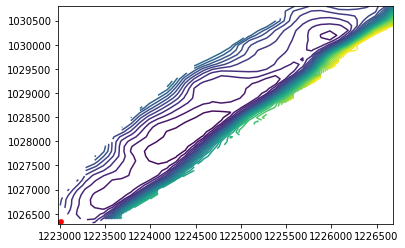

In [7]:
fig, ax = plt.subplots()

ax.contour(xx,yy,z2, levels=np.linspace(df['Z'].min(),df['Z'].max(),30))

for contour in measure.find_contours(z2,7790):
    ax.plot(contour[:, 1]+df['X'].min(), contour[:, 0]+df['Y'].min(), linewidth=5, color='r')

In [8]:


c = measure.find_contours(z2,7760)

arr = np.empty((0,2))
for contour in c:
    arr=np.concatenate((arr,contour),axis=0)
    
arr[:,1] = (arr[:,1]/z2.shape[1]) * (df['X'].max() - df['X'].min()) + df['X'].min()
arr[:,0] = (arr[:,0]/z2.shape[0]) * (df['Y'].max() - df['Y'].min()) + df['Y'].min()

In [9]:
measure.find_contours(z2,2)

[]

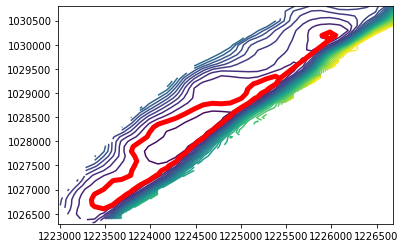

In [10]:
fig, ax = plt.subplots()

ax.contour(xx,yy,z2, levels=np.linspace(df['Z'].min(),df['Z'].max(),30))

ax.plot(arr[:, 1], arr[:, 0], linewidth=5, color='r')

# Make a pivoting to make the mesh original

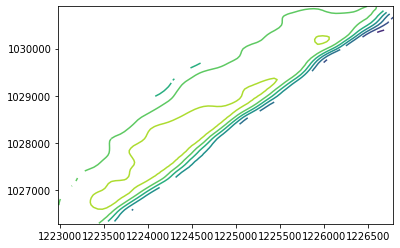

In [11]:
df['Z'] *= -1 
p = df.pivot(index='Y',columns='X',values='Z')
p.sort_index(axis=0, inplace=True)
p.sort_index(axis=1, inplace=True)

xx,yy = np.meshgrid(p.columns,p.index)

fig, ax = plt.subplots()

ax.contour(xx,yy,p.values)

# Make the surface object

In [12]:
top = vc.surface(x=xx,y=yy,z=p.values)
bottom = vc.surface(x=xx,y=yy,z=p.values-10)

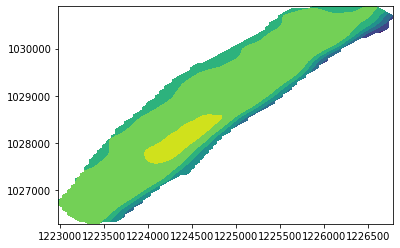

In [13]:
top.contourf(levels=5)

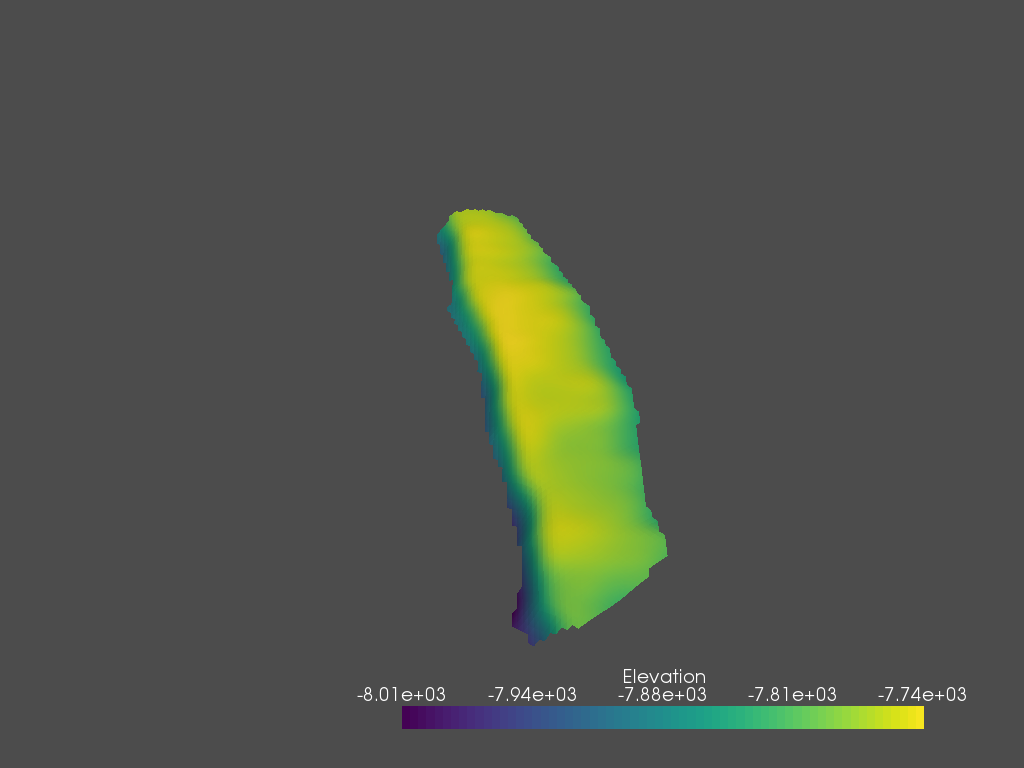

In [14]:
ss = top.structured_surface_vtk()
ss.plot(notebook=True)

In [15]:
levels = np.linspace(-7790,-7760,25)

top_area = top.get_contours_area(levels=levels,group=True)
bottom_area = bottom.get_contours_area(levels=levels,group=True)

                 y             x   level   n
0     1.026293e+06  1.223402e+06 -7790.0   0
1     1.026327e+06  1.223429e+06 -7790.0   0
2     1.026343e+06  1.223440e+06 -7790.0   1
3     1.026392e+06  1.223474e+06 -7790.0   1
4     1.026399e+06  1.223479e+06 -7790.0   1
...            ...           ...     ...  ..
6896  1.030102e+06  1.225989e+06 -7760.0  42
6897  1.030109e+06  1.225995e+06 -7760.0  42
6898  1.030151e+06  1.226018e+06 -7760.0  42
6899  1.030201e+06  1.226019e+06 -7760.0  42
6900  1.030218e+06  1.225995e+06 -7760.0  42

[6901 rows x 4 columns]


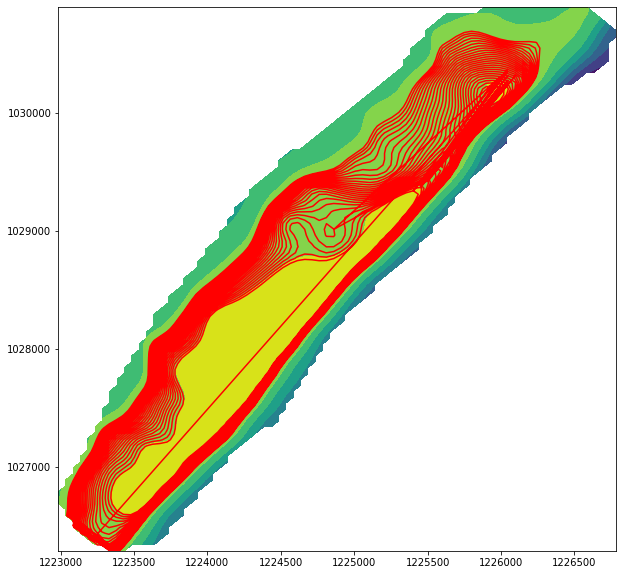

In [16]:
contours = top.get_contours(levels=levels)
print(contours)
fig, ax = plt.subplots(figsize=(10,10))

top.contourf(ax=ax)

#sns.lineplot(x='x', y='y', data=contours, hue='level')
ax.plot(contours['x'], contours['y'], color='r')

In [17]:
vol=top_area.merge(bottom_area,how='outer',left_index=True,right_index=True,suffixes=['_top','_bottom']).fillna(0)
vol['dif']= vol['area_top'] - vol['area_bottom']
vol

,area_top,area_bottom,dif
level,,,
-7790.00,849.472496,714.908487,134.564009
-7788.75,854.829604,694.269165,160.560439
-7787.50,837.015342,673.124671,163.890671
-7786.25,818.162982,651.733839,166.429143
-7785.00,801.193727,630.162319,171.031409
-7783.75,778.289509,608.793730,169.495779
-7782.50,755.904680,585.265087,170.639592
-7781.25,735.108379,560.542765,174.565615
-7780.00,714.908487,534.421467,180.487020


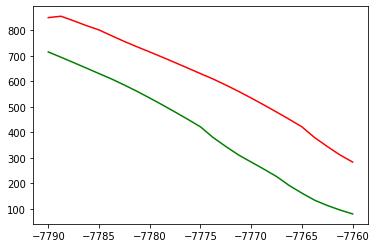

In [18]:
fig, ax = plt.subplots()

ax.plot(vol.index,vol['area_top'], color='r')
ax.plot(vol.index,vol['area_bottom'], color='g')

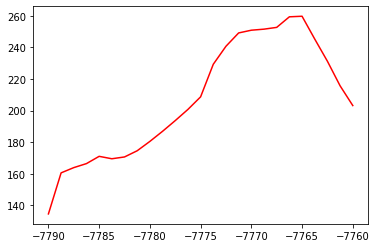

In [19]:
fig, ax = plt.subplots()

ax.plot(vol.index,vol['dif'], color='r')

In [20]:
from scipy.integrate import simps
rv=simps(vol.index,vol['dif'])

rv

-534837.8769487644

In [21]:
vol

,area_top,area_bottom,dif
level,,,
-7790.00,849.472496,714.908487,134.564009
-7788.75,854.829604,694.269165,160.560439
-7787.50,837.015342,673.124671,163.890671
-7786.25,818.162982,651.733839,166.429143
-7785.00,801.193727,630.162319,171.031409
-7783.75,778.289509,608.793730,169.495779
-7782.50,755.904680,585.265087,170.639592
-7781.25,735.108379,560.542765,174.565615
-7780.00,714.908487,534.421467,180.487020


# surface group 

In [22]:
sg = vc.surface_group()

In [23]:
sg.add_surface({'top':top,'bottom':bottom})

In [24]:
rv, ar= sg.get_volume(top_surface='top',bottom_surface='bottom',levels = np.linspace(-7790,-7760,25))

print('rv ',rv)
print(ar)

rv  -6259.176319591703
            area_top  area_bottom         dif
level                                        
-7790.00  849.472496   714.908487  134.564009
-7788.75  854.829604   694.269165  160.560439
-7787.50  837.015342   673.124671  163.890671
-7786.25  818.162982   651.733839  166.429143
-7785.00  801.193727   630.162319  171.031409
-7783.75  778.289509   608.793730  169.495779
-7782.50  755.904680   585.265087  170.639592
-7781.25  735.108379   560.542765  174.565615
-7780.00  714.908487   534.421467  180.487020
-7778.75  694.269165   507.384006  186.885159
-7777.50  673.124671   479.462332  193.662339
-7776.25  651.733839   450.993018  200.740821
-7775.00  630.162319   421.455177  208.707142
-7773.75  608.793730   379.450075  229.343655
-7772.50  585.265087   344.519403  240.745684
-7771.25  560.542765   311.358516  249.184249
-7770.00  534.421467   283.509032  250.912435
-7768.75  507.384006   255.806730  251.577277
-7767.50  479.462332   226.760323  252.702010
-7766.25  4

In [143]:
x = np.linspace(10,20,100)
y = np.linspace(10,20,100)

xx, yy = np.meshgrid(x,y)

#zz = np.full(xx.shape,5)
zz = np.power(np.power(5,2) - np.power(xx-15,2) - np.power(yy-15,2),0.5)

invalid value encountered in power


In [144]:
test=vc.surface(x=xx,y=yy,z=zz)

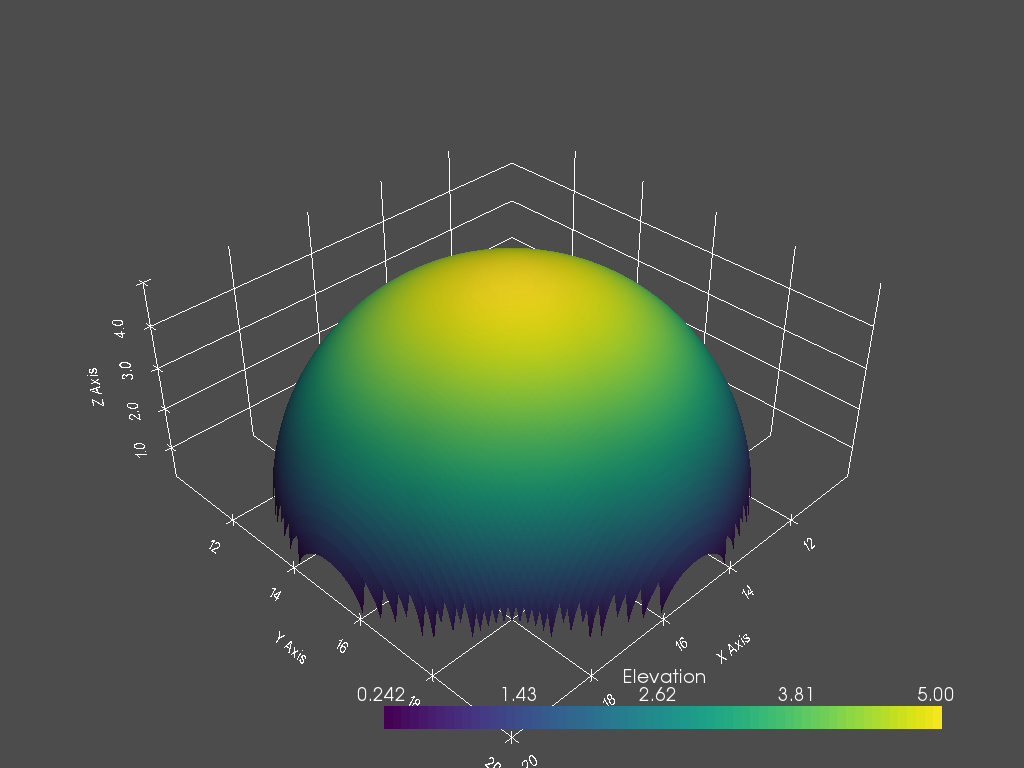

In [145]:
test.structured_surface_vtk().plot(notebook=True, show_grid=True)


In [146]:
zmin=np.nanmin(zz)
zmax=np.nanmax(zz)

levels = np.linspace(0,10,1000)

#test.get_contours_area(c=1, levels=levels)
#test.contour(levels=levels)

In [147]:
rv,ar = test.get_volume(c=1,levels=levels)
rv

167.97480350894426

In [148]:
ar

,area
level,
0.250250,0.000000
0.260260,0.000000
0.270270,0.000000
0.280280,0.000000
0.290290,0.000000
...,...
4.954955,1.371051
4.964965,1.064583
4.974975,0.757894


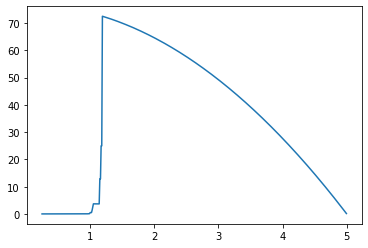

In [149]:
plt.plot(ar.index,ar['area'])

In [112]:
yc= np.power(np.power(10,2) - np.power(x-20,2),0.5)

In [115]:
vc.poly_area(x,yc)

156.9109019600901